In [158]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
from pyscf.dft import numint
import api as pyq 
import matplotlib.pyplot as plt
import importlib
import os
import h5py
import pdb
import pyscf
import numpy as np
from pyscf.scf.hf import dump_scf_summary
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/usr/local/anaconda3/lib/python3.9/site-packages/pyscf/__init__.py


In [159]:
from math import pi
mol = gto.M(atom="H 0. 0. 0.", spin=1, basis=f'ccecpccpvdz', unit='bohr')
mf = scf.UKS(mol)
scf_checkfile = "scf.hdf5"
mf.kernel()

converged SCF energy = -0.477845859825719  <S^2> = 0.75  2S+1 = 2


-0.47784585982571914

In [160]:
dm = mf.make_rdm1()
kin = mf.mol.intor_symmetric('int1e_kin')
ein = mf.mol.intor_symmetric('int1e_nuc')
j, k= mf.get_jk(mf.mol, dm)

In [161]:
#Ekin
ekin = np.einsum('ij,sji->', kin, dm).real
#EI
ei = np.einsum('ij,sji->', ein, dm).real
#EJ
ej = 0.5*np.einsum('sij,sji->', j, dm).real
ek = 0.5*np.einsum('sij,sji->', k, dm).real
#ENUC
enuc = mf.energy_nuc()
print('e1', ekin + ei, 'coul', ej, 'nuc', enuc)
#Compare to PYSCF
mf.energy_tot()
print(mf.scf_summary)

e1 -0.49929912957429773 coul 0.304064527517932 nuc 0
{'e1': -0.4992991295742977, 'coul': 0.304064527517932, 'exc': -0.2826112577693535, 'nuc': 0}


In [162]:
#Grid
size = 1000
pos = np.zeros((size, 3))
for i in range(3):
    pos[:,i] = np.random.normal(0, 2, size)
r = np.linalg.norm(pos, axis=1)
pos.shape

(1000, 3)

In [163]:
#Overlaps
aox = dft.numint.eval_ao(mol, pos, deriv=2)
ao0 = aox[0]
ao1 = aox[1:4]
ao2 = aox[4:4]
orb_coeffs = mf.mo_coeff[0]

#Density Matrix
dm = mf.make_rdm1()

In [164]:
mo_value = np.einsum('ij,sjk,sk->ik', ao0, mf.mo_coeff, mf.mo_occ)
rho = np.einsum('ij,ji->i', mo_value, mo_value.T)

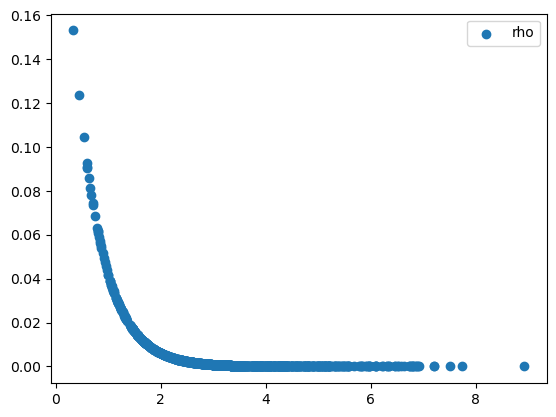

In [165]:
#user RHO
plt.scatter(r, rho, label='rho')
plt.legend()

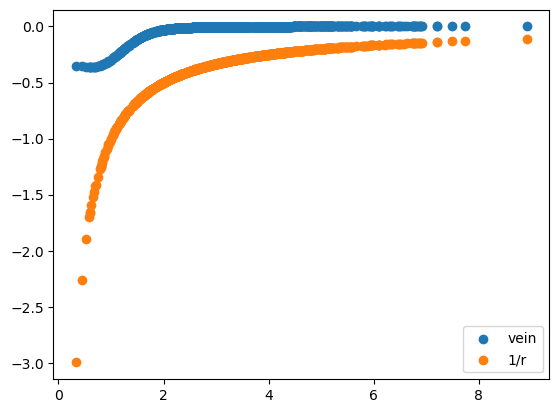

In [166]:
#EIN vs 1/r
vein = np.einsum('ij,jk,ki->i', ao0, ein, ao0.T).real
plt.scatter(r, vein, label='vein')
plt.scatter(r, -1./r, label='1/r')
plt.legend()

In [167]:
vh = []
eh = []
for i, ri in enumerate(pos):
    with mol.with_rinv_origin(ri):
        # pdb.set_trace()
        vh.append(np.einsum('ij,sij->', mol.intor('int1e_rinv'), dm).real)
        eh.append(np.einsum('ij,sij', mol.intor('int1e_rinv'), dm).real*rho[i])
vh = np.array(vh)  
vh_2 = np.einsum('ij,sjk,ki->i', mo_value, j, mo_value.T).real

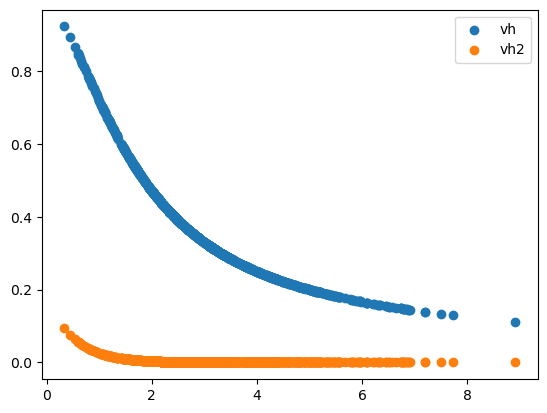

In [168]:
plt.scatter(r, vh, label='vh')
plt.scatter(r, vh_2, label='vh2')
# plt.xlim((0,5))
# plt.ylim((-2,2))
plt.legend()

In [169]:
# Above curve is inconsistent, lets calculate Eh using with regular grid to calculate the total hartree energy
mol = mf.mol
coords = mf.grids.coords
weights = mf.grids.weights
ao_reg_grid = numint.eval_ao(mol, coords)

mo_value_grid = np.einsum('ij,sjk,sk->ik', ao_reg_grid, mf.mo_coeff, mf.mo_occ)
mo_value_grid.shape
rho_grid = np.einsum('ij,ji, i->i', mo_value_grid, mo_value_grid.T, weights)
r_grid = np.linalg.norm(coords, axis=1)
print('Tot e: ', np.sum(rho_grid))

Tot e:  0.999999999900023


In [170]:
# using 4 different ways: https://github.com/pyscf/pyscf/blob/master/examples/1-advanced/031-MEP.py
# method 2 is wrong, does not solve poisson equation
vh = []
eh = []
for i, ri in enumerate(coords):
    with mol.with_rinv_origin(ri):
        vh.append(np.einsum('ij,sij->', mol.intor('int1e_rinv'), dm).real)
        eh.append(np.einsum('ij,sij->', mol.intor('int1e_rinv'), dm).real*rho_grid[i])
vh = np.array(vh)
eh = np.array(eh)
vh_2 = np.einsum('ij,sjk,ki->i', mo_value_grid, j, mo_value_grid.T).real    


from pyscf import df
fakemol = gto.fakemol_for_charges(coords)
vh_3 = np.einsum('ijp,sij->p', df.incore.aux_e2(mol, fakemol), mf.make_rdm1())

vh_4 = np.einsum('pij,sij->p', mol.intor('int1e_grids', grids=coords), mf.make_rdm1())

In [186]:
# Calculate XC energy 
rho_orig_u = numint.eval_rho(mol, ao_reg_grid, dm[0], xctype='LDA')
rho_orig_d = numint.eval_rho(mol, ao_reg_grid, dm[1], xctype='LDA')
rho_orig=[rho_orig_u, rho_orig_d]
excd, vxcs  = dft.libxc.eval_xc('LDA,VWN', rho_orig, spin=1)[:2]
# vxc = vxcs[0]
print(np.einsum('i,si,i->', excd, rho_orig, weights))
print(np.einsum('is,si,i->', vxcs[0], rho_orig, weights))
nelec, exc2, vxc2 = dft.numint.nr_vxc(mol, mf.grids, 'LDA, VWN', dm, spin=1)
print('nr_vxc:', exc2)

-0.2826112577693553
-0.37275194912328263
nr_vxc: -0.2826112577693535


In [184]:
vxc2.shape

(2, 5, 5)

In [108]:
#Total energies compared
eh_1 = 0.5 *  np.einsum('i,i->', vh, rho_grid)
print(eh_1, ej)
eh_2 = np.einsum('i,i->', vh_2, rho_grid)
print(eh_2, ej)
eh_3 = 0.5 * np.einsum('i,i->', vh_3, rho_grid)
print(eh_3, ej)
eh_4 = 0.5 * np.einsum('i,i->', vh_4, rho_grid)
print(eh_4, ej)

0.30406452745816626 0.304064527517932
0.022481363340532808 0.304064527517932
0.30406452745816626 0.304064527517932
0.30406452745816626 0.304064527517932


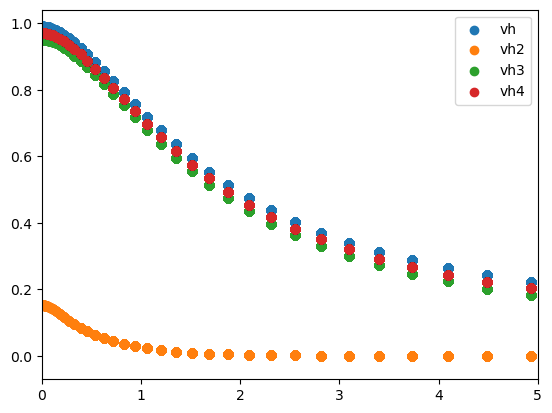

In [109]:
# plot as a function of r
plt.scatter(r_grid, vh+0.02, label='vh')
plt.scatter(r_grid, vh_2, label='vh2')
plt.scatter(r_grid, vh_3-0.02, label='vh3')
plt.scatter(r_grid, vh_4, label='vh4')
plt.xlim((0,5))
# plt.ylim((-2,2))
plt.legend()

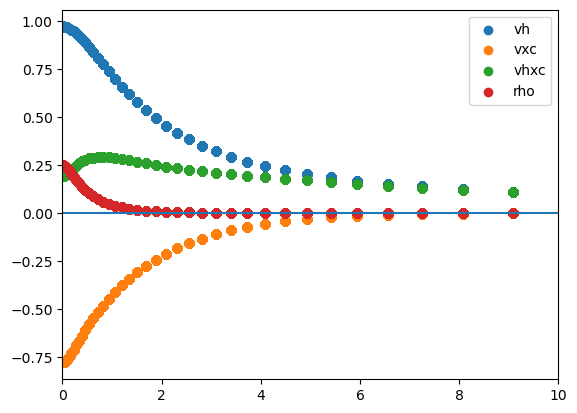

In [185]:
# Compare Vxc and Vh (self interaction error)
rho_u_reg = numint.eval_rho(mol, ao_reg_grid, dm[0], xctype='LDA')
rho_d_reg = numint.eval_rho(mol, ao_reg_grid, dm[1], xctype='LDA')
rho_reg = [rho_u_reg, rho_d_reg]
excd, vxcs  = dft.libxc.eval_xc('LDA', rho_reg, spin=1)[:2]
vxc = vxcs[0][:, 0]
plt.scatter(r_grid, vh, label='vh')
plt.scatter(r_grid, vxc, label='vxc')
plt.scatter(r_grid, vh+vxc, label='vhxc')
plt.scatter(r_grid, rho_u_reg, label='rho')
plt.xlim((0,10))
plt.axhline(0)
plt.legend()

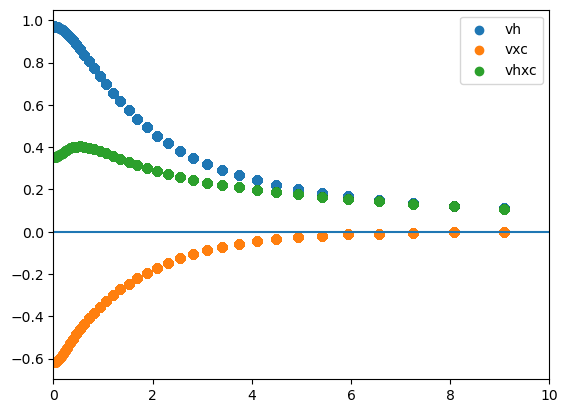

In [151]:
# Compare Vxc and Vh (self interaction error)
rho_reg = numint.eval_rho(mol, ao_reg_grid, dm, xctype='LDA')
excd, vxcs  = dft.libxc.eval_xc('LDA', rho_reg)[:2]
vxc = vxcs[0]
plt.scatter(r_grid, vh, label='vh')
plt.scatter(r_grid, vxc, label='vxc')
plt.scatter(r_grid, vh+vxc, label='vhxc')
plt.xlim((0,10))
plt.axhline(0)
plt.legend()